# Multilayer Geometric Perceptron (MLGP)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
# load the seeds:
seeds = np.load('seeds.npy')
# select and set a seed:
SEED = seeds[0]
np.random.seed(SEED)

import torch
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim

import copy

import matplotlib.pyplot as plt
import matplotlib.collections as mcol
import matplotlib.transforms as mtransforms

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from utils import (build_mlgp, build_vanilla, build_baseline, identity,
                   score, get_tetris_data, create_test_set,
                   construct_isomorphism_transformation, random_rotation_matrix,
                   embed_points, transform_points, unembed_points, 
                   draw_sphere, set_axes_equal, HandlerMultiPathCollection)

### Create the main dataset

In [3]:
# get the data:
(Xtrain, Ytrain), (Xval, Yval) = get_tetris_data(total_size=10000, train_size=1000, distortion=0.0)

output_dim = len(set(Ytrain.numpy()))

## Train the MLGP on the main data

In [4]:
# set the seed here:
torch.manual_seed(SEED)

# instantiate the model:
model = build_mlgp(input_shape=Xtrain.shape[1:], output_dim=output_dim, hidden_layer_sizes=[4], bias=False)

print(model)
print('total number of parameters:', sum([np.prod(p.size()) for p in filter(lambda p: p.requires_grad, model.parameters())]))
print()

if torch.cuda.is_available():
    model = model.cuda()
    Xtrain, Ytrain = Xtrain.float().cuda(), Ytrain.cuda()
    Xval, Yval = Xval.float().cuda(), Yval.cuda()


# define the loss and optimizer:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 20000
batch_size = len(Xtrain)
n_batches = len(Xtrain) // batch_size


# train the model:
for i in range(epochs): 
    for j in range(n_batches):          
        Xbatch = Xtrain[j*batch_size:(j+1)*batch_size,]
        Ybatch = Ytrain[j*batch_size:(j+1)*batch_size]

        y_pred = model(Xbatch)
        loss = criterion(y_pred, Ybatch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred.detach_()
        acc = score(y_pred, Ybatch)

        y_val_pred = model(Xval)
        y_val_pred.detach_()
        val_loss = criterion(y_val_pred, Yval)
        val_acc = score(y_val_pred, Yval)

        if i % 500 == 0:
            print('epoch: %d,  batch: %d,  cost: %.3f,  val_cost: %.3f,  acc:  %.3f,  val_acc: %.3f' % (i, j, loss.item(), val_loss.item(), acc, val_acc))

print('epoch: %d,  batch: %d,  cost: %.3f,  val_cost: %.3f,  acc:  %.3f,  val_acc: %.3f' % (i, j, loss.item(), val_loss.item(), acc, val_acc))


model: MLGP (ours)
PointCMLP(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=20, out_features=4, bias=False)
  )
  (out_layer): Linear(in_features=6, out_features=8, bias=False)
)
total number of parameters: 128

epoch: 0,  batch: 0,  cost: 3.746,  val_cost: 3.723,  acc:  0.118,  val_acc: 0.126
epoch: 500,  batch: 0,  cost: 1.744,  val_cost: 1.824,  acc:  0.352,  val_acc: 0.309
epoch: 1000,  batch: 0,  cost: 1.451,  val_cost: 1.557,  acc:  0.504,  val_acc: 0.455
epoch: 1500,  batch: 0,  cost: 1.128,  val_cost: 1.229,  acc:  0.637,  val_acc: 0.569
epoch: 2000,  batch: 0,  cost: 0.887,  val_cost: 1.001,  acc:  0.717,  val_acc: 0.670
epoch: 2500,  batch: 0,  cost: 0.763,  val_cost: 0.871,  acc:  0.751,  val_acc: 0.712
epoch: 3000,  batch: 0,  cost: 0.683,  val_cost: 0.781,  acc:  0.768,  val_acc: 0.731
epoch: 3500,  batch: 0,  cost: 0.609,  val_cost: 0.693,  acc:  0.785,  val_acc: 0.752
epoch: 4000,  batch: 0,  cost: 0.522,  val_cost: 0.583,  acc:  0.822,  val_acc: 0.795
epoc

## Evaluate on the test set

In [5]:
# create the test set:
Xtest, Ytest = create_test_set(distortion=0.0)

if torch.cuda.is_available():
    Xtest, Ytest = Xtest.cuda(), Ytest.cuda()

# evaluate on the test data:
Ytest_pred = model(Xtest).detach_()
test_acc = score(Ytest_pred, Ytest)

print('test acc:', np.round(test_acc, 5))

test acc: 0.91982


## Isometry test

In [6]:
def modify_and_compare_models(model, rotation, translation, data, labels, distortion=0.0, verbose=False):         
    if_cuda = torch.cuda.is_available()
    
    # construct isomorphism:
    T = construct_isomorphism_transformation(rotation, translation)    
    
    # modify the model -- transfrom the hidden layer spheres in the conformal space:
    transformed_model = copy.deepcopy(model)
    state_dict = transformed_model.state_dict()

    name = 'hidden_layers.0.weight' 
    spheres = state_dict[name]
    spheres_numpy = spheres.detach().cpu().numpy()
    transformed_spheres = transform_points(spheres_numpy.reshape(-1, 5), T).reshape(spheres_numpy.shape)

    state_dict[name].copy_(torch.autograd.Variable(spheres.data.new(transformed_spheres)))
    transformed_model.load_state_dict(state_dict)
   
    # transform the data in the Euclidean R3 space:
    transformed_data = data.reshape(-1, 3) @ rotation.T + translation
    transformed_data = transformed_data.reshape(data.shape)     

    ## or equivalently in the conformal ME3 space (i.e., R5 implementation-wise):
    ## NOTE: the embedded points are in the canonical form, i.e., (x1, x2, x3, 0.5*|x|^2, 1)
    # embedded_points = embed_points(data.reshape(-1, 3))
    # transformed_points = transform_points(embedded_points, T)
    # transformed_data = unembed_points(transformed_points).reshape(data.shape)

    # add noise to the transformed data:
    transformed_data += np.random.uniform(low=-distortion, high=distortion, size=transformed_data.shape)

    # compare the predictions:
    labels_tensor = torch.from_numpy(labels)
    if if_cuda:
        labels_tensor = labels_tensor.cuda()

    # original model on the original data:
    data_tensor = torch.from_numpy(data).float()  
    if if_cuda:
        data_tensor = data_tensor.cuda()        
    original_model_output = model(data_tensor).data
    original_model_predictions = torch.argmax(original_model_output, axis=1)
    score_1 = score(original_model_output, labels_tensor)
   

    # transformed model on the (perturbed) transformed data:
    transformed_data_tensor = torch.from_numpy(transformed_data).float()
    if if_cuda:
        transformed_data_tensor = transformed_data_tensor.cuda()
    transformed_model_output = transformed_model(transformed_data_tensor).data
    transformed_model_predictions = torch.argmax(transformed_model_output, axis=1)
    score_2 = score(transformed_model_output, labels_tensor)
    

    # transformed model on the original data:
    transformed_model_orig_data_output = transformed_model(data_tensor).data
    transformed_model_orig_data_predictions = torch.argmax(transformed_model_orig_data_output, axis=1)
    score_3 = score(transformed_model_orig_data_output, labels_tensor)


    # original model on the transformed data:
    original_model_transformed_data_output = model(transformed_data_tensor).data
    original_model_transformed_data_predictions = torch.argmax(original_model_transformed_data_output, axis=1)
    score_4 = score(original_model_transformed_data_output, labels_tensor)


    if verbose:
        print('rotation in R3:\n', rotation)
        print('\ntranslation in R3:\n', translation)
        print('\ntransformation isomorphism in R5:\n', T.reshape(5, 5))
        
        # check the hidden layer parameters of the two models:
        print('\noriginal model spheres:\n', model.state_dict()[name].reshape(4, 4, 5), '\n\ntransformed model spheres:\n', transformed_model.state_dict()[name].reshape(4, 4, 5))

        # print('\n\ndata:\n', data)
        # print('\noriginal_model(data):\n', original_model_output) 
        print('\noriginal_model_predictions:\n', original_model_predictions) 
        print('\noriginal_model(data) ACC:', score_1)

        # print('\n\ntransformed_data:\n', transformed_data)
        # print('\ntransformed_model(transformed_data):\n', transformed_model_output)    
        print('\ntransformed_model_predictions:\n', transformed_model_predictions)  
        print('\ntransformed_model(transformed_data) ACC:', score_2)

        # print('\n\ntransformed_data:\n', transformed_data)
        # print('\ntransformed_model(transformed_data):\n', transformed_model_output)    
        print('\ntransformed_model_orig_data_predictions:\n', transformed_model_orig_data_predictions)  
        print('\ntransformed_model(data) ACC:', score_3)

        # print('\n\ntransformed_data:\n', transformed_data)
        # print('\ntransformed_model(transformed_data):\n', transformed_model_output)    
        print('\noriginal_model_transformed_data_predictions:\n', original_model_transformed_data_predictions)  
        print('\noriginal_model(transformed_data) ACC:', score_4)
        
        print()

    return score_1, score_2, score_3, score_4

In [7]:
n_experiments = 10000
np.random.seed(100000000)

data = Xtest.cpu().numpy()
labels = Ytest.cpu().numpy()

all_scores = []
verbose = False
for i in range(n_experiments):

    # generate random rotation and translation:
    rotation =  random_rotation_matrix()
    translation = np.expand_dims(np.random.uniform(low=-3., high=3., size=(3)), axis=0)
    
    # transform the model and compare with the original one:
    scores = modify_and_compare_models(model, rotation, translation, data, labels, distortion=0.0, verbose=verbose)
    all_scores.append(scores)
    
    if i % 1000 == 0:
        print('i:', i, '\tscores:', 100 * np.round(scores, 6))
              
    verbose = False

i: 0 	scores: [91.9822 91.9822 86.7411 86.8067]
i: 1000 	scores: [91.9822 91.9822 78.23   78.85  ]
i: 2000 	scores: [91.9822 91.9822 86.87   86.1822]
i: 3000 	scores: [91.9822 91.9822 87.5867 87.3611]
i: 4000 	scores: [91.9822 91.9822 83.2556 84.5333]
i: 5000 	scores: [91.9822 91.9822 82.7378 84.0589]
i: 6000 	scores: [91.9822 91.9822 90.1    88.5144]
i: 7000 	scores: [91.9822 91.9822 85.2633 85.7689]
i: 8000 	scores: [91.9822 91.9822 87.9544 87.3978]
i: 9000 	scores: [91.9822 91.9822 80.9744 81.1567]


In [8]:
score_means = 100 * np.round(np.mean(all_scores, axis=0), 6) 
score_stds  = 100 * np.round(np.std(all_scores, axis=0), 6)
names = ['original_model(original_data)', 'transformed_model(transformed_data)', 'transformed_model(original_data)', 'original_model(transformed_data)']
for name, m, s in zip(names, score_means, score_stds):
    print('\n'+name+':\n', m, '+/-', s)


original_model(original_data):
 91.9822 +/- 0.0

transformed_model(transformed_data):
 91.9822 +/- 0.0

transformed_model(original_data):
 86.1098 +/- 3.4574000000000003

original_model(transformed_data):
 86.089 +/- 3.4464


## Geometric neuron (i.e., hidden unit) analysis

In [9]:
# get the hidden layer parameters (n_geometric_neurons x 20):
hidden = model.hidden_layers[0].weight.detach().cpu().numpy() # size = (4, 20)

In [10]:
hyperspheres_hidden = []
norm_hyperspheres_hidden = []
centers_norm_hidden = []
centers_hidden = []
radii_hidden = []
last_coord_hidden = []

for n in range(len(hidden)):
    ##### analyze the entire 20-weight vector ######
    hps = hidden[n, :]
    hyperspheres_hidden.append(hps)

    ##### the last elements ######    
    hps_last = hps[4::5]
    last_coord_hidden.append(hps_last)
    
    # p-normalize the spheres, i.e., obtain the canonical embedding form:
    hps_norm = np.array([hps[i*5:(i+1)*5]/hps_last[i] for i in range(4)])
    norm_hyperspheres_hidden.append(hps_norm)
    centers_hidden.append(np.array([hps_norm.flatten()[i*5:i*5+3] for i in range(4)]))
    
    ###### the hypersphere radii  ######
    hps_but_last = hps_norm.flatten()[3::5]
    
    # 1) compute ||c||^2:
    cs = np.array([np.sum(hps_norm.flatten()[i*5:i*5+3]**2) for i in range(4)])    
    
    # 2) compute r from 
    #                     (||c||^2 - r^2)/2 = hps_but_last
    r = np.sqrt(cs - 2*hps_but_last)
    radii_hidden.append(r)
    

hyperspheres_hidden = np.array(hyperspheres_hidden).reshape(4, 4, 5)
centers_hidden = np.array(centers_hidden)
last_coord_hidden = np.array(last_coord_hidden)
norm_hyperspheres_hidden = np.array(norm_hyperspheres_hidden)
radii_hidden = np.array(radii_hidden)

    
print('hyperspheres:', hyperspheres_hidden.shape, '\n', np.round(hyperspheres_hidden, 5))
print('\n\ncenters:', centers_hidden.shape, '\n', centers_hidden)
print('\n\nnormalized hyperspheres:', norm_hyperspheres_hidden.shape, '\n', np.round(norm_hyperspheres_hidden, 2))
print('\n\nradii:\n', radii_hidden)

hyperspheres: (4, 4, 5) 
 [[[ -3.20207   3.51402   4.41872  -1.52013   0.18045]
  [  1.73019  -2.07825  -2.25662  -1.51503  -0.09759]
  [  6.92918  -7.91164 -10.24141  -1.60134  -0.32099]
  [ -5.34834   6.27646   7.98115  -1.34361   0.18863]]

 [[  4.82096  -3.06766   3.28017  -1.53942   0.10766]
  [ -2.31073   1.5236   -1.69791  -1.48052  -0.09362]
  [-10.8189    7.70252  -7.54988  -1.90525  -0.21522]
  [  8.13666  -6.10162   5.93284  -1.84637   0.17915]]

 [[ -3.71096  -4.68243   2.77911  -1.12967  -0.19617]
  [  2.04288   2.44921  -1.41912  -1.1335    0.11208]
  [  9.26892  11.05822  -6.26208  -1.04309   0.2622 ]
  [ -7.48502  -8.67574   4.85943  -1.03899  -0.19781]]

 [[ -2.44314  -2.43571  -3.3376   -1.50891   0.23403]
  [  1.40196   1.01329   1.57941  -1.21778  -0.22161]
  [  5.58948   5.86306   8.93873  -1.43025  -0.38168]
  [ -4.32179  -4.535    -7.1475   -1.1928    0.33963]]]


centers: (4, 4, 3) 
 [[[-17.745407   19.474176   24.487856 ]
  [-17.72852    21.29494    23.122654 ]

## Visualization

In [11]:
#%matplotlib qt5

In [12]:
label_names = get_tetris_data(only_label_names=True)

### All the spheres represented by a single geometric neuron

- each spherical decision surface of a single geometric neuron classifies the corresponding point of the input shape (specified by the markers)

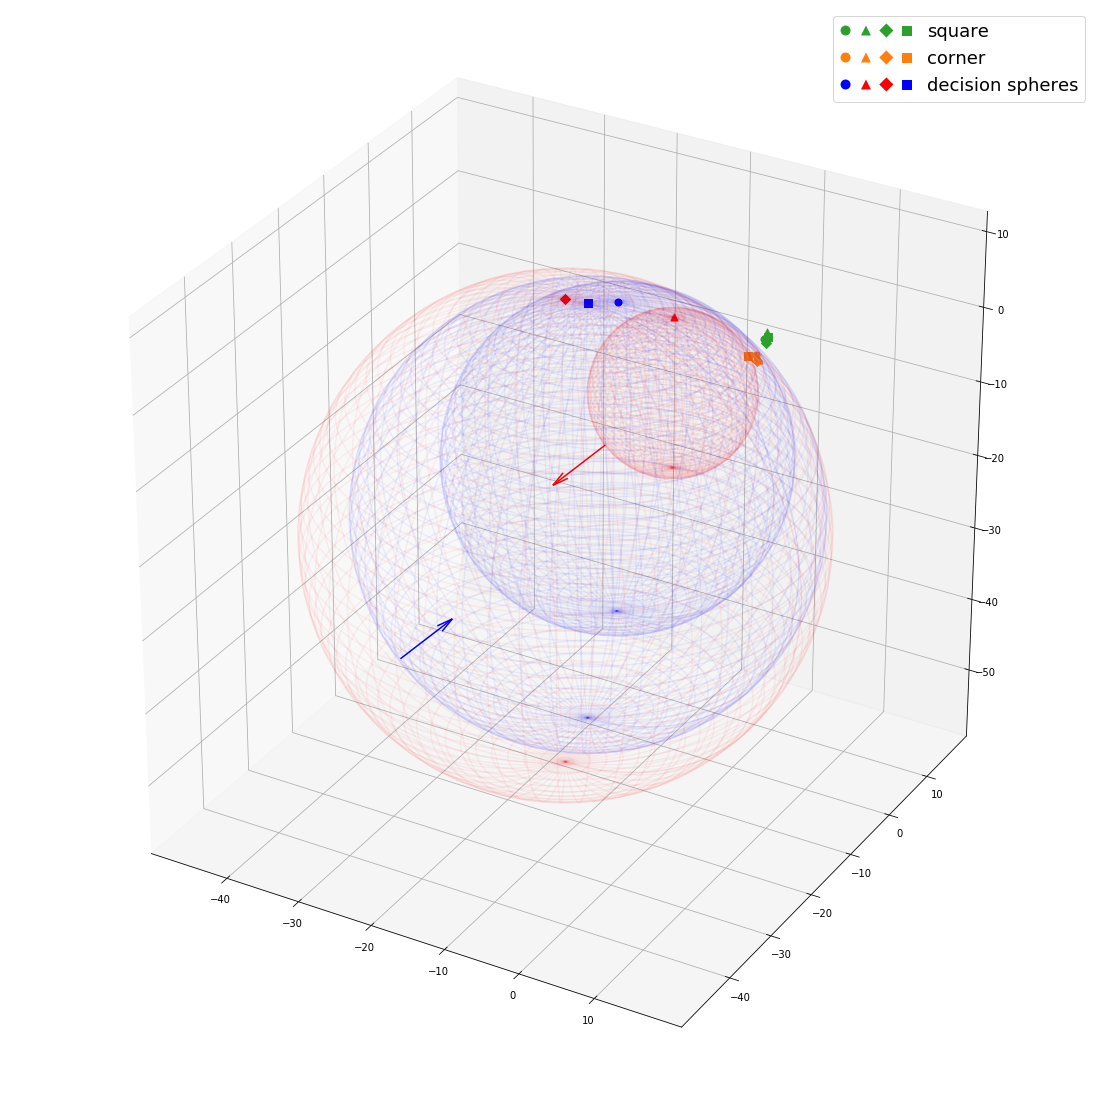

In [13]:
# geometric neuron idx (0-3):
n = 3 



# select and embed the input:
# x = Xtest[64:72]
x = Xval[64:72] # size = (8, 4, 3), i.e., eight shapes consisting of four 3D points each
embed_term = -torch.sum(x**2, axis=2) / 2
second_last_term = -torch.ones(len(x), x.shape[1], 1).float()

if torch.cuda.is_available():
    second_last_term = second_last_term.cuda()
    
x = torch.cat((x, second_last_term, embed_term.view(-1, x.shape[1], 1)), dim=2)
Xembed = x.cpu().numpy()



# plot the samples:
legend_elements = []
markers = ['o', '^', 'D', 's']
colors = ['C4', 'C0', 'C2', 'C3', 'C1', 'C5', 'C6', 'C7']

fig = plt.figure(1, figsize=(50, 20))
ax = fig.add_subplot(111, projection='3d')

# display only "corner" and "square":
for i in [2, 4]:
    shp = []
    for m in range(4):
        xs, ys, zs = Xembed[i,m,0], Xembed[i,m,1], Xembed[i,m,2] 
        shp.append(ax.scatter(xs, ys, zs, s=50, marker=markers[m], color=colors[i], label=str(label_names[i])))#+'[%s]'%str(m)))
    legend_elements.append(shp)
    
    
    
# draw the normalized hyperspheres of the chosen n-th geometric unit:
poles = []
for m in range(len(radii_hidden[n])):    
    # the normalized hypersphere is red if the last element of its
    # non-normalized (learned) version is negative;
    # such a hypershpere represents an inverted decision surface,
    # i.e., if an input feature is classified as class +, it will be outside the sphere, 
    # and vice versa
    flag = m in [1, 3]
    
    col = 'b' if np.sign(last_coord_hidden[n][m]) >= 0 else 'r' 
    
    pole = draw_sphere(centers_hidden[n][m], radii_hidden[n][m], ax, pole_marker_size=50, marker=markers[m], ind=m, color=col, alpha=0.05, draw_normal=flag)
    poles.append(pole)


    
# work with the legend:
plt.rc('legend', fontsize=14)
# get attributes:
PCs = []
for shp, color in zip(legend_elements, ['C2', 'C1']):
    paths = []
    sizes = []
    facecolors = []
    for plot in shp:
        paths.append(plot.get_paths()[0])
        sizes.append(plot.get_sizes()[0])

    # make proxy artist out of a collection of markers:
    PC = mcol.PathCollection(paths, sizes=[100], transOffset=ax.transData, facecolors=color)
    PC.set_transform(mtransforms.IdentityTransform())
    PCs.append(PC)
    
paths = []
sizes = []
facecolors = []
for plot in poles:
    paths.append(plot.get_paths()[0])
    sizes.append(plot.get_sizes()[0])
    facecolors.append(plot.get_facecolors()[0])

PC = mcol.PathCollection(paths, sizes=[100], transOffset=ax.transData, facecolors=facecolors)
PC.set_transform(mtransforms.IdentityTransform())
PCs.append(PC)

ax.legend(PCs, ['square', 'corner', 'decision spheres'], handler_map = {type(PC): HandlerMultiPathCollection() for PC in PCs}, fontsize=18, scatterpoints = len(paths), scatteryoffsets = [.5], handlelength = len(paths))



# adjust the view:
# minmax = [-100, 100]
# ax.set_xlim(minmax)
# ax.set_ylim(minmax) 
# ax.set_zlim(minmax) 

# set_axes_equal(ax)
ax.set_aspect('equal')

### One of the spheres in a single geometric neuron
   - the sphere classifies the corresponding point in the input shapes

				the scalar product
with the norm hypersphere (displayed) 		with the non-norm (i.e., learned) hypershpere

square[4]
X.dot(S4_norm) =  -50.73253 			X.dot(S4) =  -17.23025

corner[4]
X.dot(S4_norm) =  39.1538 			X.dot(S4) =  13.297775



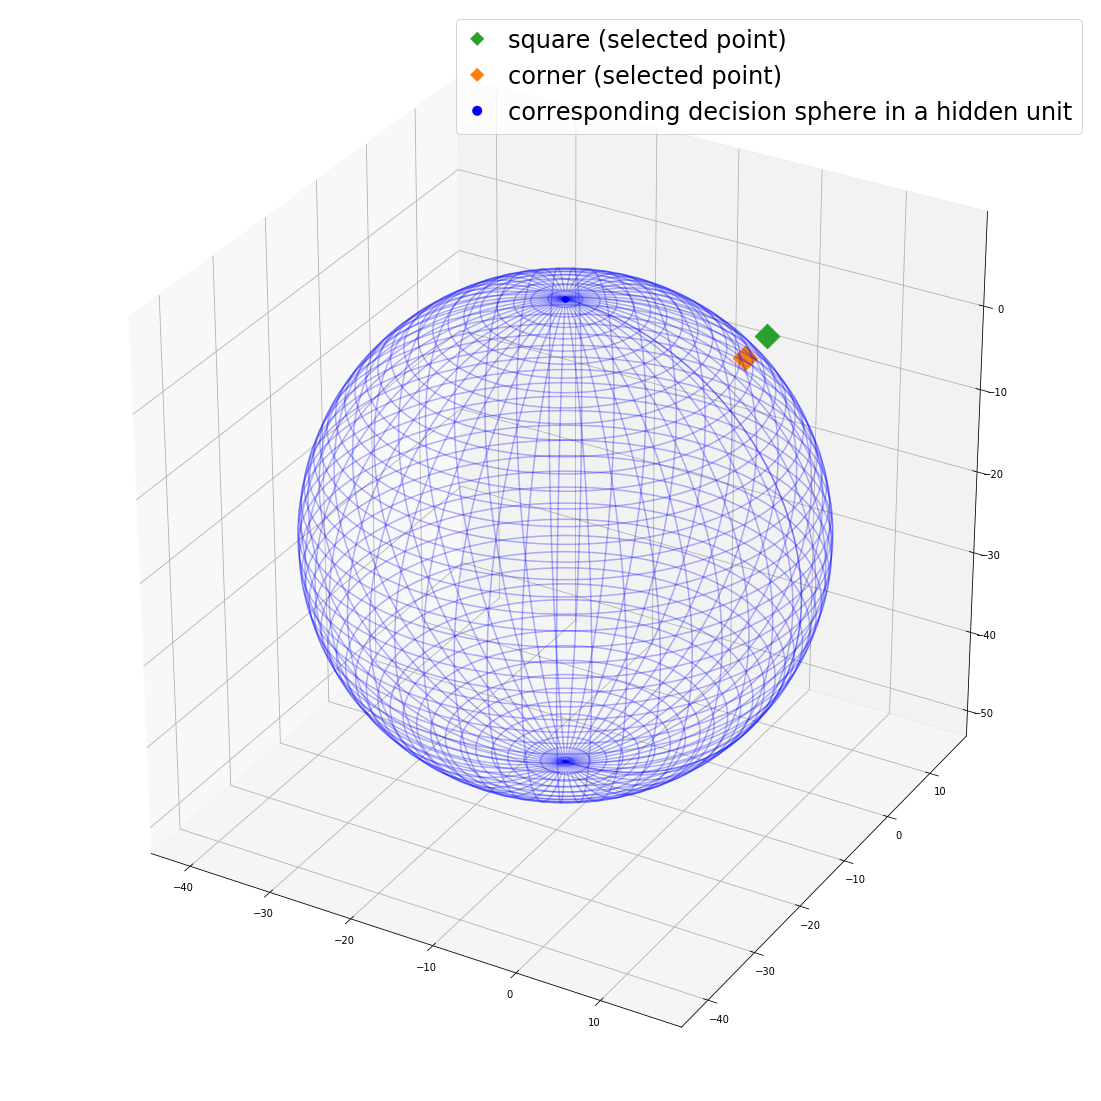

In [14]:
# geometric neuron idx (0-3):
n = 3
# the index of a shape point and the corresponding decision sphere (0-3):
m = 3 



# embed the input:
# x = Xtest[64:72]
x = Xval[64:72] # size = (8, 4, 3), i.e., eight shapes consisting of four 3D points each
embed_term = -torch.sum(x**2, axis=2) / 2
second_last_term = -torch.ones(len(x), x.shape[1], 1).float()

if torch.cuda.is_available():
    second_last_term = second_last_term.cuda()
    
x = torch.cat((x, second_last_term, embed_term.view(-1, x.shape[1], 1)), dim=2)



# plot the samples:
legend_elements = []
markers = ['o', '^', 's', 'D']
colors = ['C4', 'C0', 'C2', 'C3', 'C1', 'C5', 'C6', 'C7']

fig = plt.figure(1, figsize=(50, 20))
ax = fig.add_subplot(111, projection='3d')

print('\t\t\t\tthe scalar product\nwith the norm hypersphere (displayed) \t\twith the non-norm (i.e., learned) hypershpere\n')
for i in [2, 4]: 
    shp = []
    xs, ys, zs = Xembed[i,m,0], Xembed[i,m,1], Xembed[i,m,2] 
    shp.append(ax.scatter(xs, ys, zs, s=300, marker=markers[m], color=colors[i], label=str(label_names[i])))
    legend_elements.append(shp)
    
    # now get the scalar product with the norm hypersphere:
    scalar_product = Xembed[i, m] @ norm_hyperspheres_hidden[n][m]
    print(label_names[i]+str([n+1]))
    print('X.dot(S%d_norm) = '%(n+1), scalar_product, '\t\t\tX.dot(S%d) = '%(n+1), scalar_product*last_coord_hidden[n][m])
    print()

    
    
# draw the chosen normalized hypersphere of the chosen n-th geometric unit:
poles = []
col = 'b' if np.sign(last_coord_hidden[n][m]) >= 0 else 'r' 
pole = draw_sphere(centers_hidden[n][m], radii_hidden[n][m], ax, marker='o', ind=m, color=col, alpha=0.3, draw_normal=False)
poles.append(pole)



# work with the legend:
plt.rc('legend', fontsize=14)
# get attributes:
PCs = []
for shp, color in zip(legend_elements, ['C2', 'C1']):
    paths = []
    sizes = []
    facecolors = []
    for plot in shp:
        paths.append(plot.get_paths()[0])
        sizes.append(plot.get_sizes()[0])

    # make proxy artist out of a collection of markers:
    PC = mcol.PathCollection(paths, sizes=[100], transOffset=ax.transData, facecolors=color)
    PC.set_transform(mtransforms.IdentityTransform())
    PCs.append(PC)
    
paths = []
sizes = []
facecolors = []
for plot in poles:
    paths.append(plot.get_paths()[0])
    sizes.append(plot.get_sizes()[0])
    facecolors.append(plot.get_facecolors()[0])

PC = mcol.PathCollection(paths, sizes=[100], transOffset=ax.transData, facecolors=facecolors)
PC.set_transform(mtransforms.IdentityTransform())
PCs.append(PC)

ax.legend(PCs, ['square (selected point)', 'corner (selected point)', 'corresponding decision sphere in a hidden unit'], handler_map = {type(PC): HandlerMultiPathCollection() for PC in PCs}, fontsize=24, scatterpoints = len(paths), scatteryoffsets = [.5], handlelength = len(paths))



# adjust the view:
# minmax = [-100, 100]
# ax.set_xlim(minmax)
# ax.set_ylim(minmax) 
# ax.set_zlim(minmax) 

# set_axes_equal(ax)
ax.set_aspect('equal')